In [9]:
import cv2
import numpy as np
import pickle
import os
import itertools
import tqdm
import random
from PIL import Image

from text_preprocessing import Tokenizer, pad_sequences
from gensim.models import KeyedVectors
from gensim.utils import tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import models

import matplotlib.pyplot as plt

In [10]:
BASE_DIR = "dataset/"
DATASET_DIR = BASE_DIR + "text_data/"
IMAGES_DIR = BASE_DIR + "images/all_items/"

# Global Parameter Variables
MAX_SEQUENCE_LENGTH = 100
NUM_WORDS_TOKENIZER = 50000
EMBEDDING_DIM = 300
BATCH_SIZE = 32

In [11]:
def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (256, 256))
  img = img.astype(np.float32) / 255
  return np.moveaxis(img, 2, 0)

def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)

In [12]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

room_to_items = {}

for item_url, room_url_list in item_to_rooms_map.items():
  item_id = item_url.split("/")[-1].split(".jpg")[0]
  if not os.path.exists(IMAGES_DIR + item_id + ".jpg"):
      print(item_url + " does not exist")
      continue

  for room_url in room_url_list:
    room_id = room_url.split("/")[-1].split(".jpg")[0]
    if room_id not in room_to_items:
      room_to_items[room_id] = [item_id]
    else:
      room_to_items[room_id].append(item_id)
    
with open(BASE_DIR + "train_sets.pkl", "rb") as file:
    train_sets = pickle.load(file)
with open(BASE_DIR + "val_data.pkl", "rb") as file:
    val_pairs, y_val = pickle.load(file)
with open(BASE_DIR + "preprocessed_text.pkl", "rb") as file:
    item_to_info = pickle.load(file)

images/890.333.75.jpg does not exist
images/991.333.98.jpg does not exist
images/990.612.97.jpg does not exist


In [24]:
emb_dir = "intermediate_fusion_embeddings"
all_embeddings = [pickle.load(open(os.path.join(emb_dir, fname), "rb"))
                  for fname in os.listdir(emb_dir) if fname.endswith('.p')]
all_embeddings.append(pickle.load(open("intermediate_fusion_controls/embeddings_text_only.p", "rb")))

image_ids, embs = zip(*all_embeddings)
assert all(m == image_ids[0] for m in image_ids)
image_ids = image_ids[0]

In [6]:
import emblaze

In [25]:
embeddings = emblaze.EmbeddingSet([
    emblaze.Embedding({
        emblaze.Field.POSITION: emb,
        emblaze.Field.COLOR: np.zeros(len(emb))
    }, label=label, metric='cosine') for emb, label in zip(embs,
                                          ['emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'text_only'])
])
embeddings

Embeddings are not 2D, skipping alignment


<EmbeddingSet with 6 embeddings:
	<Embedding with 2158 items, 2 fields (position, color)>
	<Embedding with 2158 items, 2 fields (position, color)>
	<Embedding with 2158 items, 2 fields (position, color)>
	<Embedding with 2158 items, 2 fields (position, color)>
	<Embedding with 2158 items, 2 fields (position, color)>
	<Embedding with 2158 items, 2 fields (position, color)>>

In [26]:
embeddings.compute_neighbors(n_neighbors=100)

In [27]:
reduced = embeddings.project(method=emblaze.ProjectionTechnique.ALIGNED_UMAP)
reduced

/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/umap/umap_.py:905: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/umap/spectral.py:255: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


<EmbeddingSet with 6 embeddings:
	<Embedding with 2158 items, 3 fields (position, color, highlight)>
	<Embedding with 2158 items, 3 fields (position, color, highlight)>
	<Embedding with 2158 items, 3 fields (position, color, highlight)>
	<Embedding with 2158 items, 3 fields (position, color, highlight)>
	<Embedding with 2158 items, 3 fields (position, color, highlight)>
	<Embedding with 2158 items, 3 fields (position, color, highlight)>>

In [20]:
images = [np.array(Image.open("dataset/images/all_items/" + id + ".jpg").resize((224, 224)))
          for id in image_ids]
img_thumbnails = emblaze.ImageThumbnails(images)
text_thumbnails = emblaze.TextThumbnails([item_categories[id] for id in image_ids])
thumbnails = emblaze.CombinedThumbnails([img_thumbnails, text_thumbnails])

In [28]:
w = emblaze.Viewer(embeddings=reduced, thumbnails=thumbnails)
w

Viewer(colorScheme='tableau', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 2158, 'ids'…

In [31]:
w.visibleSidebarPane = 3

# Ranking Evaluations

In [69]:
with open("dataset/train_sets.pkl", "rb") as file:
    val_pairs, y_val, _ = pickle.load(file)[0]
    
val_products = set([x for pair in val_pairs for x in pair])
val_id_indexes = [i for i, id in enumerate(image_ids) if id in val_products]
val_image_ids = [image_ids[i] for i in val_id_indexes]
val_embeddings = [emb[val_id_indexes] for emb in embs]

In [38]:
# Build pairs to rank

NUM_QUERIES = 50

val_products = sorted(val_products) # list(set(x for pair in val_pairs for x in pair)))

np.random.seed(1234)
premise_products = np.random.choice(val_products, size=min(NUM_QUERIES, len(val_products)), replace=False)
hypothesis_products = val_products

ranking_pairs = list(itertools.product(premise_products, hypothesis_products))
print(len(ranking_pairs), "pairs,", len(hypothesis_products), "products per query")

35200 pairs, 704 products per query


In [39]:
# Get the ground-truth

ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in premise_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] for item_id in premise_products]

# plt.hist([len(x) for x in ground_truth_lists], bins=np.arange(0, max(len(x) for x in ground_truth_lists), 5));

In [41]:
ranking_results = []
for id_1, id_2 in ranking_pairs:
    dots = []
    idx_1 = val_image_ids.index(id_1)
    idx_2 = val_image_ids.index(id_2)
    for emb in val_embeddings[:-1]:
        dots.append((emb[idx_1] * emb[idx_2]).sum())
    dots = np.array(dots)
    dots = 1 / (1 + np.exp(-dots))
    ranking_results.append(np.mean(dots))
ranking_results = np.array(ranking_results).reshape(len(premise_products), len(hypothesis_products))
print(ranking_results.shape)

(50, 704)


In [70]:
import math
class Evaluator:
    def __init__(self, GroundTruth):
      self.GroundTruth = GroundTruth

    def NDCG_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      DCGScore = 0
      result = []
      for i, item in enumerate(sortedRankResult[:topk]):
        if item[0] in self.GroundTruth:
          result.append((item, i))
      DCGScore = sum([item[0][1]/math.log(item[1]+2, 2) for item in result])
      IDCGScore = sum([1/math.log(i+2,2) for i in range(topk)])
      NDCG = DCGScore / IDCGScore

      return NDCG
    
    def Score_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      return sum(i[1] for i in sortedRankResult[:topk] if i[0] in self.GroundTruth) / topk
    
    def Precision(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(topkresult)

    def Recall(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(self.GroundTruth)
    
    def FValue(self, rankresult, topk):
      precision = self.Precision(rankresult, topk)
      recall = self.Recall(rankresult, topk)
      return 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

In [44]:
# Now use the evaluator
TOP_K = 10

ndcg = np.zeros(len(premise_products))
score = np.zeros(len(premise_products))
precision = np.zeros(len(premise_products))
recall = np.zeros(len(premise_products))
fvalue = np.zeros(len(premise_products))
for i, (ground_truth, rankings) in enumerate(zip(ground_truth_lists, ranking_results)):
    evaluator = Evaluator(ground_truth)
    rankings = {product: output for product, output in zip(hypothesis_products, rankings)}
    ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
    score[i] = evaluator.Score_Eval(rankings, TOP_K)
    precision[i] = evaluator.Precision(rankings, TOP_K)
    recall[i] = evaluator.Recall(rankings, TOP_K)
    fvalue[i] = evaluator.FValue(rankings, TOP_K)
print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))

with open("intermediate_fusion_rankings_{}_queries.pkl".format(len(premise_products)), "wb") as file:
    pickle.dump({
        "ndcg": ndcg,
        "score": score,
        "precision": precision,
        "recall": recall,
        "fvalue": fvalue
    }, file)

NDCG: 0.2011 (95% CI 0.045-0.357)
Score: 0.1210 (95% CI -0.004-0.246)
Precision: 0.1340 (95% CI -0.005-0.273)
Recall: 0.0812 (95% CI -0.036-0.199)
FValue: 0.0946 (95% CI -0.017-0.206)


In [71]:
# Now try ranking all pairs
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

all_similarities = [1 / (1 + np.exp(-np.dot(emb, emb.T))) for emb in val_embeddings]
all_similarities = [np.mean(np.stack(all_similarities), axis=0)]
for sims in all_similarities:
    TOP_K = 10

    ndcg = np.zeros(len(val_products))
    score = np.zeros(len(val_products))
    precision = np.zeros(len(val_products))
    recall = np.zeros(len(val_products))
    fvalue = np.zeros(len(val_products))
    for i, (ground_truth, sim_row) in enumerate(zip(ground_truth_lists, sims)):
        evaluator = Evaluator(ground_truth)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product != val_image_ids[i]}
        ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
        score[i] = evaluator.Score_Eval(rankings, TOP_K)
        precision[i] = evaluator.Precision(rankings, TOP_K)
        recall[i] = evaluator.Recall(rankings, TOP_K)
        fvalue[i] = evaluator.FValue(rankings, TOP_K)
    print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
    print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
    print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
    print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
    print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))
    print("")

NDCG: 0.0564 (95% CI -0.157-0.270)
Score: 0.0515 (95% CI -0.133-0.236)
Precision: 0.0566 (95% CI -0.143-0.256)
Recall: 0.0268 (95% CI -0.085-0.139)
FValue: 0.0324 (95% CI -0.079-0.144)



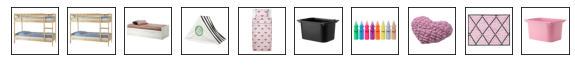

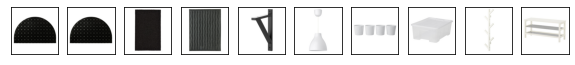

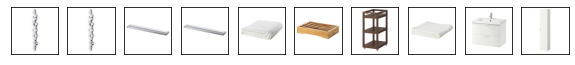

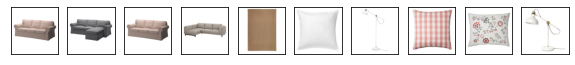

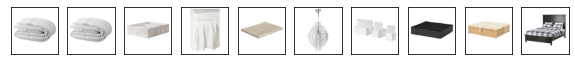

In [75]:
# Let's look at some examples
example_idxs = np.random.choice(len(val_image_ids), size=5, replace=False)
for idx in example_idxs:
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 10, 1)
    plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[idx] + ".jpg").resize((224, 224)))
    plt.xticks([])
    plt.yticks([])
    best_idxs = np.argsort(all_similarities[0][idx])[-3:]
    for i, match_idx in enumerate(reversed(best_idxs)):
        plt.subplot(1, 10, i + 2)
        plt.imshow(Image.open("dataset/images/all_items/" + val_image_ids[match_idx] + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
    gt = list(ground_truth_lists[idx])
    true_idxs = np.random.choice(len(gt), size=6, replace=False)
    for i, match_idx in enumerate(true_idxs):
        plt.subplot(1, 10, i + 5)
        plt.imshow(Image.open("dataset/images/all_items/" + gt[match_idx] + ".jpg").resize((224, 224)))
        plt.xticks([])
        plt.yticks([])
    plt.show()

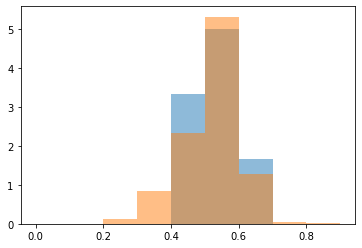

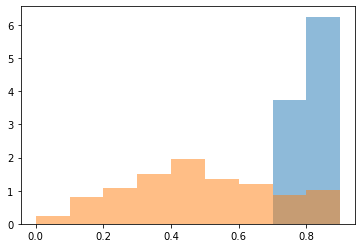

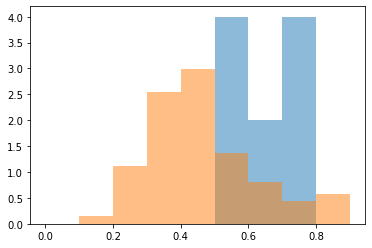

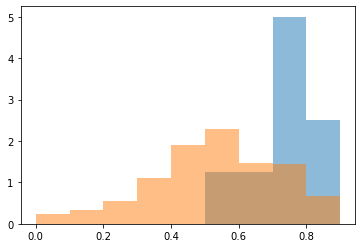

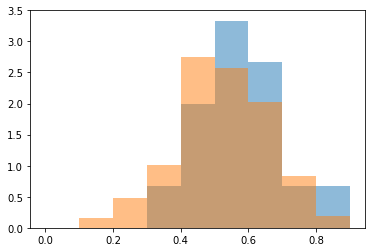

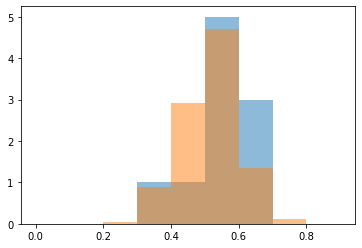

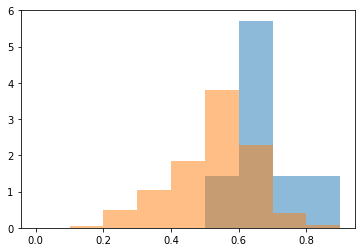

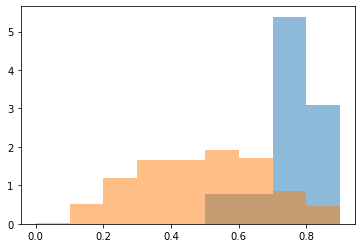

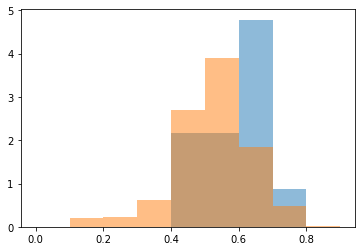

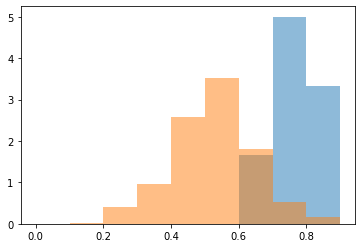

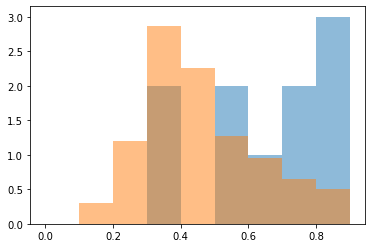

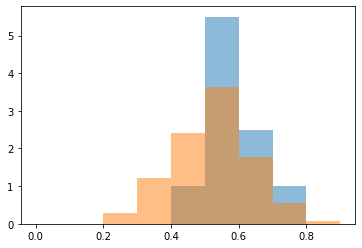

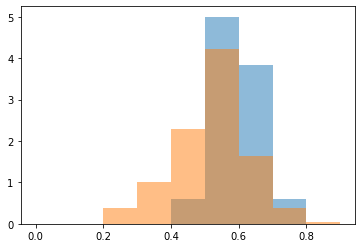

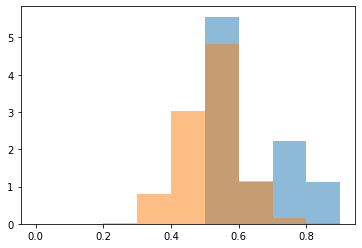

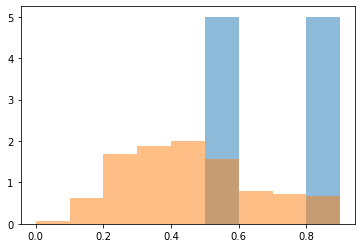

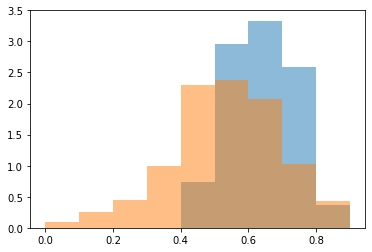

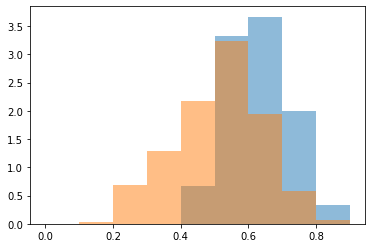

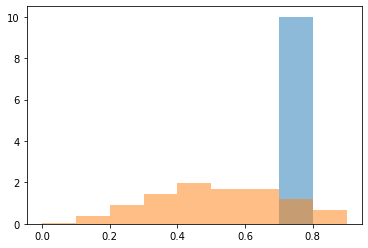

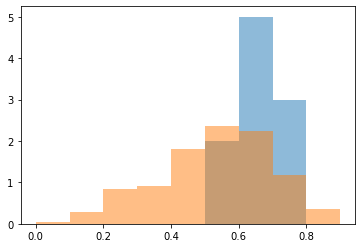

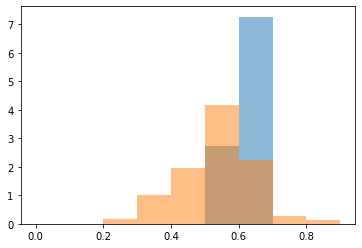

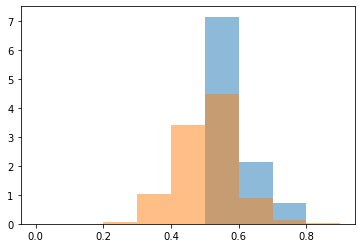

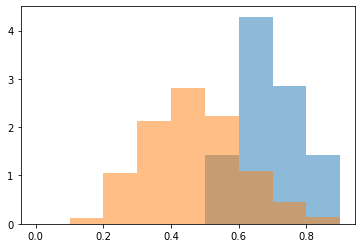

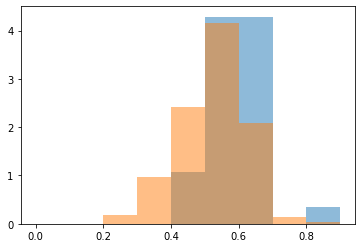

0.6512652 0.50540525 15.005502063273727 1437.9944979367262


In [81]:
# Let's see if the rankings elevate positive objects more than negative objects
pos_sims = []
pos_counts = []
neg_sims = []
neg_counts = []
for query_idx, query_id in enumerate(val_image_ids):
    sim_row = all_similarities[0][query_idx]
    rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product != query_id}
    pos = [r for id, r in rankings.items() if id in ground_truth_lists[query_idx]]
    neg = [r for id, r in rankings.items() if id not in ground_truth_lists[query_idx]]
    pos_sims.append(np.mean(pos))
    pos_counts.append(len(pos))
    neg_sims.append(np.mean(neg))
    neg_counts.append(len(neg))
    if np.random.uniform() < 0.01:
        plt.figure()
        plt.hist(pos, alpha=0.5, bins=np.arange(0, 1, 0.1), density=True)
        plt.hist(neg, alpha=0.5, bins=np.arange(0, 1, 0.1), density=True)
        plt.show()
print(np.mean(pos_sims), np.mean(neg_sims), np.mean(pos_counts), np.mean(neg_counts))

In [ ]:
# Triplet ranking problem - given two objects, find a most compatible third one